<a href="https://colab.research.google.com/github/shubhamsrivastava951/Usyd_Machine_Learning/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab9 - Clustering I

Today we will learn unsupervised machine learning models: clustering algorithms. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but two of the simplest to understand are the algorithms known as *hierarchical clustering* and *k-means clustering*.

We begin with the standard imports and downloading of relevant data:

In [1]:
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
import numpy as np
from PIL import Image
from numpy import asarray

In [2]:
#Downloading files
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1kW1X0o-yseKA_UuliOyfQdwr5ff7p7uA'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('text.pkl')

id = '141o_PVV6oxe_gyoERUaipMS5v6qW3U67'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('titles.pkl')

id = '1YbnlRt3Xon5r64XqNlJSdkxYjCcj3HGu'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('beach-sunset-thailand.jpg')


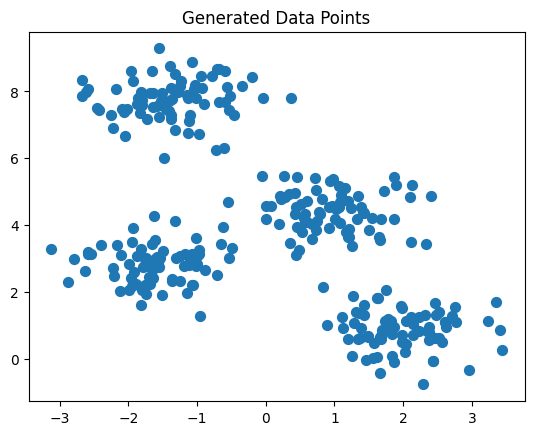

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate sample data (300 points, 4 clusters)
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Plot the generated data points
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Generated Data Points")
plt.show()


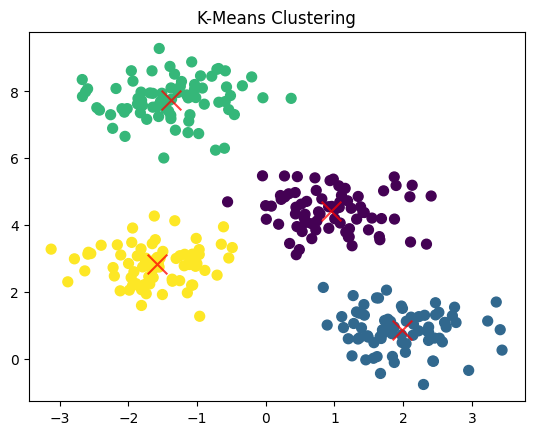

In [9]:
# Create a KMeans model with 4 clusters
kmeans = KMeans(n_clusters=4)

# Fit the model to the data
kmeans.fit(X)

# Get the predicted cluster labels for each data point
y_kmeans = kmeans.predict(X)

# Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids of the clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

plt.title("K-Means Clustering")
plt.show()


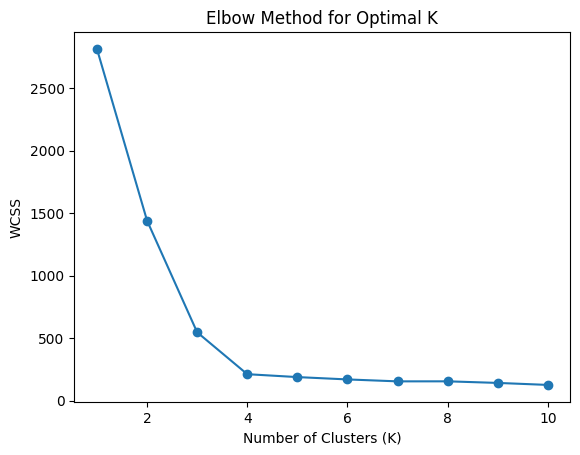

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate sample data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# List to store the WCSS (within-cluster sum of squares)
wcss = []

# Try different numbers of clusters (from 1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS for the current number of clusters

# Plot the WCSS vs number of clusters
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


#k-Means Clustering

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

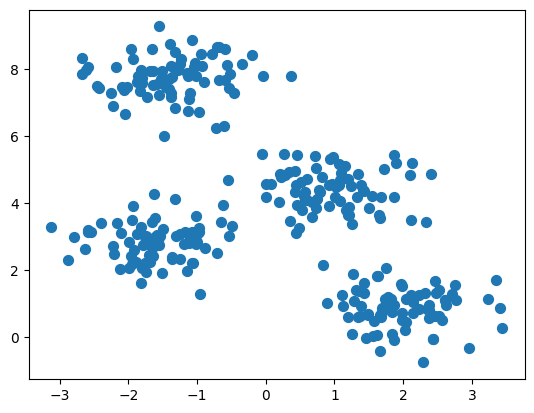

In [5]:
from sklearn.datasets import make_blobs  # Corrected import

# Now, you can use make_blobs as expected
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Example of plotting the blobs
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()


By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [6]:
from sklearn.cluster import KMeans

# select the parameter k for number of clusters
k=4
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data coloured by these predicted labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

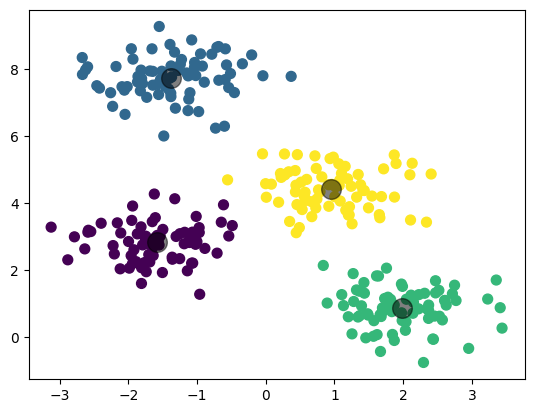

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean of the cluster

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](06.00-Figure-Code.ipynb#Interactive-K-Means).

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

<class 'str'>
cosine
[[ 2.00802058  0.83629568]
 [-1.8338064   2.68708805]
 [ 1.01675691  4.38020484]
 [-1.2427258   6.60520853]]
[2 3 2 3 2 0 1 2 3 3 1 3 2 3 0 2 2 0 3 1 0 0 2 1 1 3 0 2 1 2 3 3 2 3 3 3 3
 3 1 0 2 1 3 2 1 3 3 1 3 0 1 0 3 0 0 3 3 1 3 0 3 2 3 3 1 1 3 0 3 1 2 3 3 1
 1 3 1 2 0 3 0 2 0 0 3 2 0 2 3 3 2 0 3 1 3 2 0 0 2 1 3 0 3 0 2 0 0 2 3 2 1
 1 0 3 0 2 3 0 0 2 3 0 3 0 0 0 0 1 0 1 3 1 1 0 3 1 1 3 2 3 3 3 2 3 2 1 3 3
 3 3 3 2 3 2 0 3 3 1 0 2 3 2 2 0 2 1 1 2 0 2 2 3 0 2 3 3 0 0 2 3 0 2 1 1 3
 2 2 2 0 3 2 3 2 2 1 1 1 2 1 3 2 3 0 1 2 3 1 3 2 3 2 1 3 2 3 3 3 0 0 2 3 0
 0 1 0 1 2 3 3 2 2 3 2 0 3 2 0 3 3 1 0 2 0 3 3 3 3 1 1 3 2 1 0 2 1 1 3 0 0
 3 2 2 1 0 3 3 2 3 2 0 0 1 1 2 0 0 0 2 3 3 0 0 2 0 0 0 3 3 3 2 0 0 3 3 3 0
 0 2 2 1]


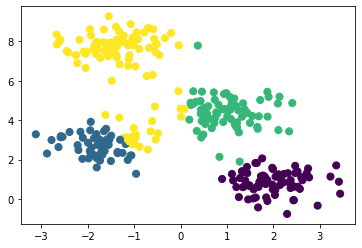

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, metric1, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    print(type(metric1))
    print(metric1)

    while True:
        # 2a. Assign labels based on closest center
        # metric can be  'cosine', 'euclidean', 'manhattan'
        #metric1 = 'euclidean'
        labels = pairwise_distances_argmin(X, centers, 1, metric1)
        #labels = pairwise_distances_argmin(X, centers, metric='cosine')
        #labels = pairwise_distances_argmin(X, centers, metric='cosine')

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4, "cosine")
print(centers)
print(labels)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### a) The number of clusters
The common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

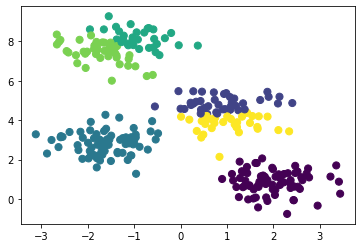

In [ ]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

#### b) k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

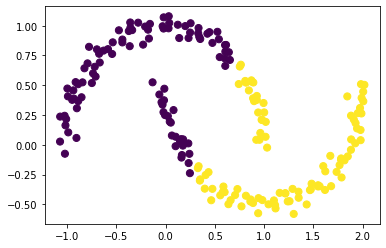

In [ ]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in our Lab on Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


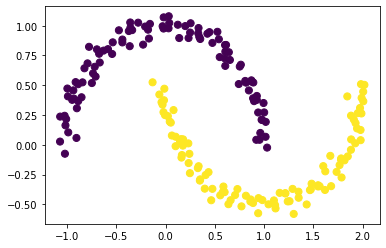

In [ ]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

## Example: *k*-means for colour compression

One interesting application of clustering is in colour compression within images.
For example, imagine you have an image with millions of colours.
In most images, a large number of the colours will be unused, and many of the pixels in the image will have similar or even identical colours.

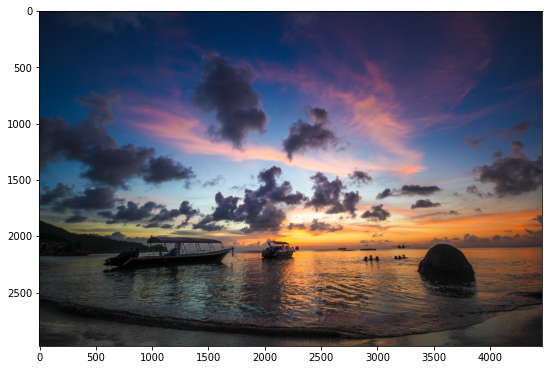

In [ ]:
# load the image
image = Image.open("./beach-sunset-thailand.jpg")
# convert image to numpy array
beach = asarray(image)

plt.figure(figsize=(9,12))
plt.rcParams["axes.grid"] = False
plt.imshow(beach)

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [ ]:
beach.shape

(2973, 4460, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional colour space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colours so that they lie between 0 and 1:

In [ ]:
data = beach / 255.0 # use 0...1 scale
data = data.reshape(-1, 3)
data.shape

(13259580, 3)

We can visualize these pixels in this colour space, using a subset of 10,000 pixels for efficiency:

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

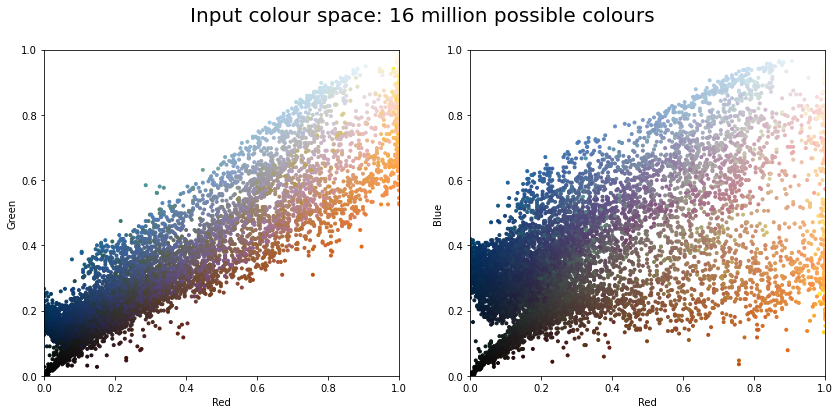

In [ ]:
plot_pixels(data, title='Input colour space: 16 million possible colours')

Now let's reduce these 16 million colours to just 16 colours, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

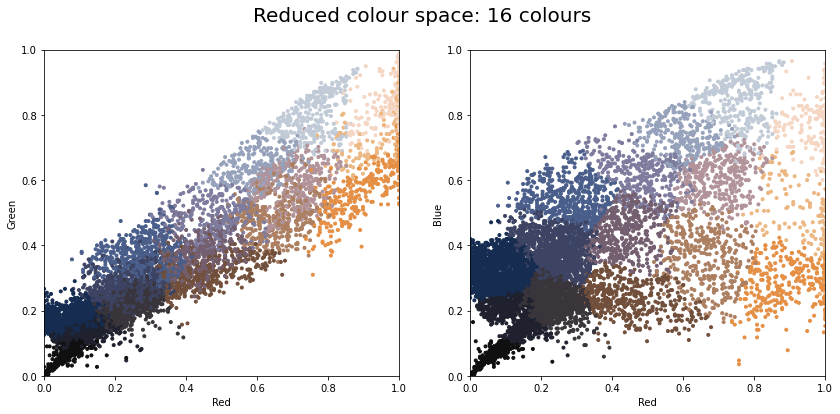

In [ ]:
###As we are using high resolution image this clustering will take two minutes.
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced colour space: 16 colours")

The result is a re-colouring of the original pixels, where each pixel is assigned the colour of its closest cluster center.
Plotting these new colours in the image space rather than the pixel space shows us the effect of this:

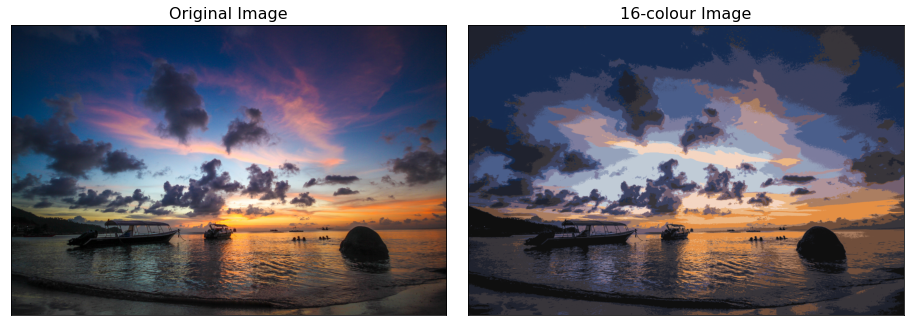

In [ ]:
beach_recoloured = new_colors.reshape(beach.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(beach)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(beach_recoloured)
ax[1].set_title('16-colour Image', size=16);

#Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis which builds a hierarchy of clusters. Agglomerative hierarchical clustering is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

Following are the steps involved in agglomerative clustering:

1. At the start, treat each data point as its own cluster. Therefore, the number of clusters at the start will be K, where K is an integer equal to the number of data points.
2. Form a cluster by joining the two closest data points resulting in K-1 clusters.
3. Form more clusters by joining the two closest clusters resulting in K-2 clusters.
4. Repeat the above three steps until one big cluster is formed.
5. Once a single cluster is formed, dendrograms are used to divide into multiple clusters depending upon the problem. We will study the concept of dendrograms in detail in an upcoming section.

There are different ways to find distance between the clusters. The distance itself can be Euclidean or Manhattan distance. Following are some of the options to measure distance between two clusters:

* Measure the distance between the closest points of two clusters.
* Measure the distance between the farthest points of two clusters.
* Measure the distance between the centroids of two clusters.
* Measure the distance between all possible combinations of points between the two clusters and take the mean.

#Movie clustering based on IMDB synopses

In this example from natural language processing (NLP) we'll cluster movies based on a distance measure between their synopses from the Internet Move Database (IMDB). First let's unpickle the data.

In [ ]:
###data_loading
synopsis = pickle.load(open('text.pkl', 'rb'))
titles = pickle.load(open('titles.pkl', 'rb'))

print("Number of titles is", len(titles))

###look at an example
print('Sample title:',titles[0])
print('Sample synopsis:',synopsis[0])


Number of titles is 100
Sample title: The Godfather
Sample synopsis:  Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adam

In [ ]:
type(titles)

list

Clustering requires a distance measure between samples, so we will need to construct a numerical representation of each synopsis.

We will do this in two steps, first we will pre-process the text and then construct a numerical representation. The natural language tool kit (nltk) is a library for text processing. We will perform two steps - tokenisation and stemming.

Tokenisation is breaking a text down into units - characters, words, or sentences for examples. Last week we used character tokenisation. This week we use sentence and then word tokenisation.

After tokenising we will clean the data by removing all tokens containing non-letter characters. We will use the re (regular expression) package to find such tokens.

Finally we will perform stemming. Stemming is the crude chopping of affixes from words to produce root forms. [Snowball stemming](https://snowballstem.org) is a stemming method concentrating on suffixes.

In [ ]:
###Synopsis data preprocessing
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

stemmer = SnowballStemmer("english")
nltk.download('punkt')
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Next we will construct a numerical representation of each synopsis. We will construct a term frequency - inverse document frequency (TF-IDF) vector. Remember the terminology from last week - a corpus is a collection of documents. Today the corpus is the collection of all the synopses. Each synopsis is a document.

term frequency *tf(t,d)* for a word *t* is the number of times it occurs in a document *d* divided by the number of words in *d*..

document frequency *df* for a word *t* is the number of times it appears in all documents in the corpus *D*. Then inverse document frequency is

*idf(t,D) = log(N/(df(t) + 1))*

Where *N* is the number of documents. Finally the *tf-idf* for a word *t* is

*tf-idf(t,d) = tf(t,d) idf(t,D)*

For each document we then construct an ordered vector of tf-idf values for each unique word in the corpus. The legth of the vector is the number of words in the whole corpus.

What commonality do two documents with similar tf-idf vectors have?

(100, 563)


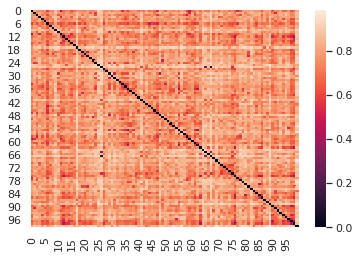

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns;

### TfidfVectorizer will perform the vectorisation. Please explore the parameters at the user guide
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(synopsis)
print(tfidf_matrix.shape)
dist = 1 - cosine_similarity(tfidf_matrix)

sns.set()
ax = sns.heatmap(dist)

In [ ]:
dist1 = 1*tfidf_matrix
print(tfidf_matrix)

  (0, 4)	0.015840237403117192
  (0, 548)	0.01612420215693917
  (0, 87)	0.013158145917863982
  (0, 168)	0.01127492073118682
  (0, 208)	0.047520712209351584
  (0, 554)	0.015840237403117192
  (0, 427)	0.08485730621728925
  (0, 1)	0.046705079955494354
  (0, 343)	0.06022813901532093
  (0, 108)	0.012147386431826087
  (0, 287)	0.015840237403117192
  (0, 299)	0.013534028158239696
  (0, 306)	0.009010032167901243
  (0, 417)	0.015307582752631105
  (0, 37)	0.01184313106771756
  (0, 15)	0.01334332279941062
  (0, 222)	0.010753148800711149
  (0, 446)	0.013158145917863982
  (0, 437)	0.008289477056589938
  (0, 24)	0.013730602286522562
  (0, 497)	0.016421379232122783
  (0, 82)	0.012305126670905985
  (0, 483)	0.02916724306696112
  (0, 169)	0.0252655923822052
  (0, 200)	0.015568359985164785
  :	:
  (99, 383)	0.08619640541457027
  (99, 358)	0.07672891325500265
  (99, 177)	0.20333482818614418
  (99, 368)	0.09393190975382117
  (99, 215)	0.13192312316278199
  (99, 438)	0.06821489514982466
  (99, 283)	0.335609

Now let's perform the agglomerative hierarchical clustering on the tf-idf vectors. We will import the necessary functions from scipy. Please look at the [user guide](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy). Which option for measuring distance are we using?

In [ ]:
from scipy.cluster.hierarchy import complete, dendrogram

linkage_matrix = complete(dist) #define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix.shape

(99, 4)

Finally let's look at the dendrogram. Do the suggested clusters make sense according to how you thought about tf-idf similarity?

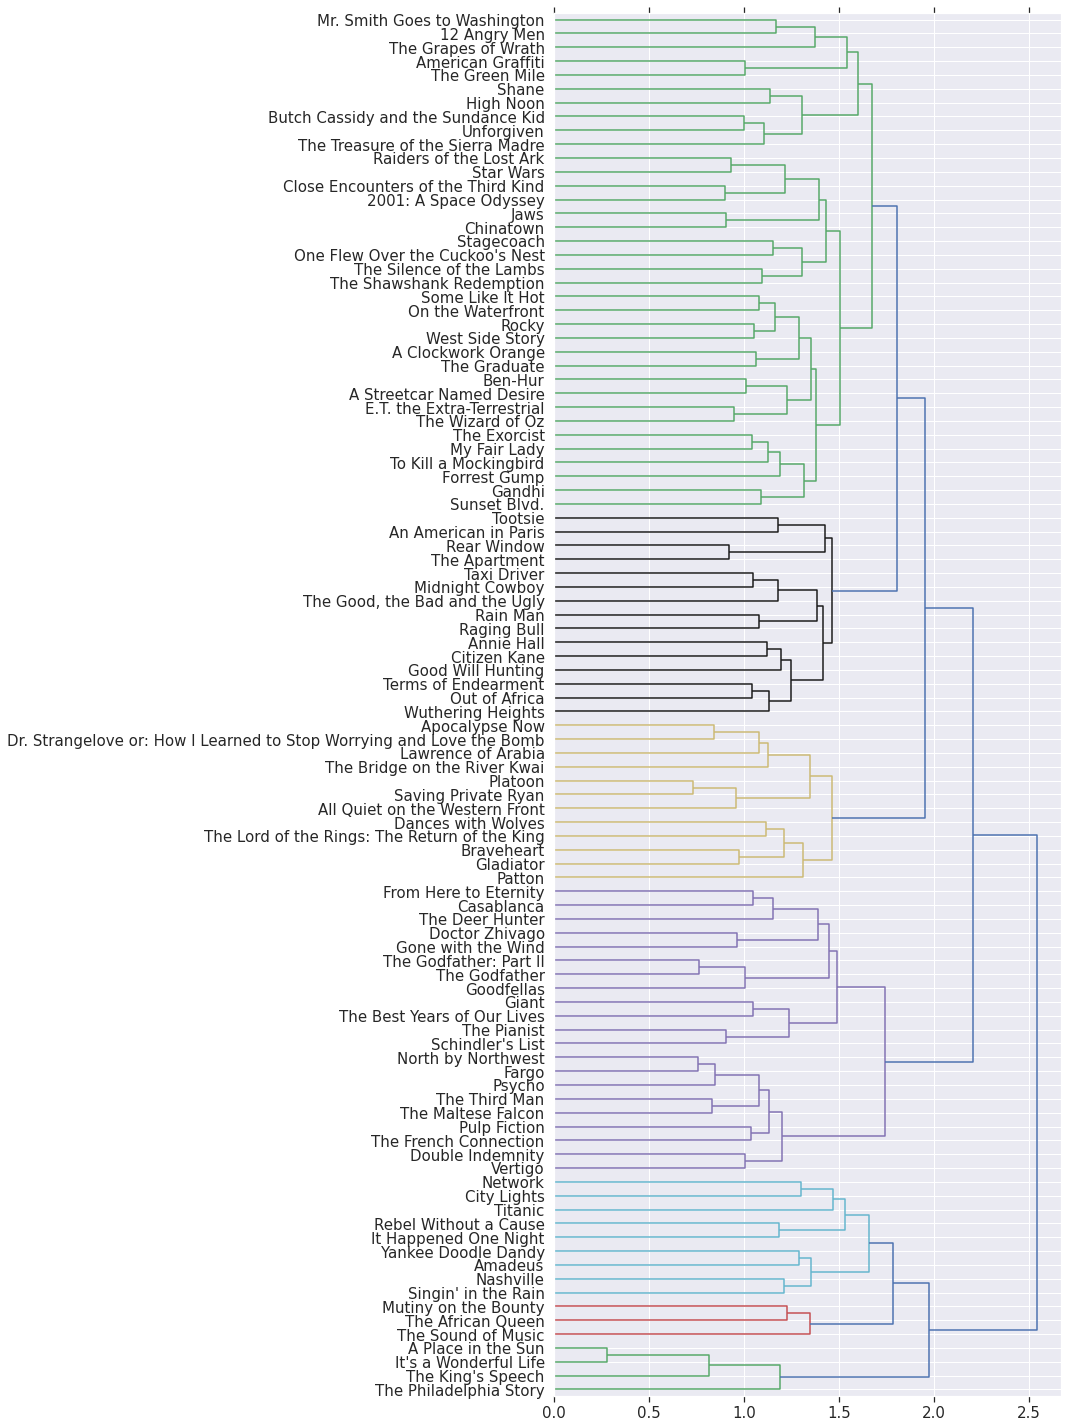

In [ ]:

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelsize=15
    )
plt.tick_params(\
    axis= 'y',          # changes apply to the y-axis
    labelsize=15
    )

plt.tight_layout() #show plot with tight layout

#save figure as ward_clusters
plt.savefig('ward_clusters.png', dpi=200)

#Exercise

##Please use k-means clustering to compress below image to 10-colors, show the compressed image, and compare it to the original image.

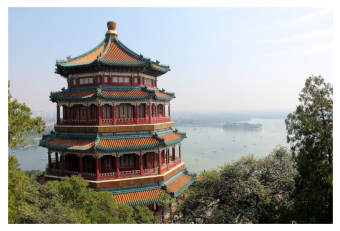

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

##Sample solution

In [ ]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

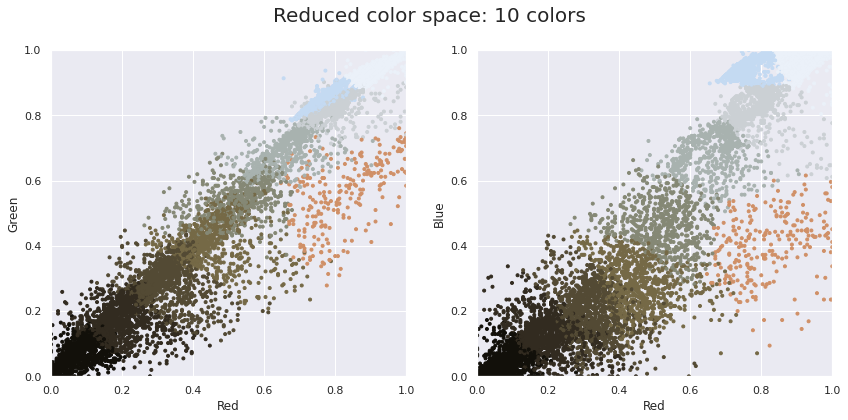

In [ ]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(10)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 10 colors")

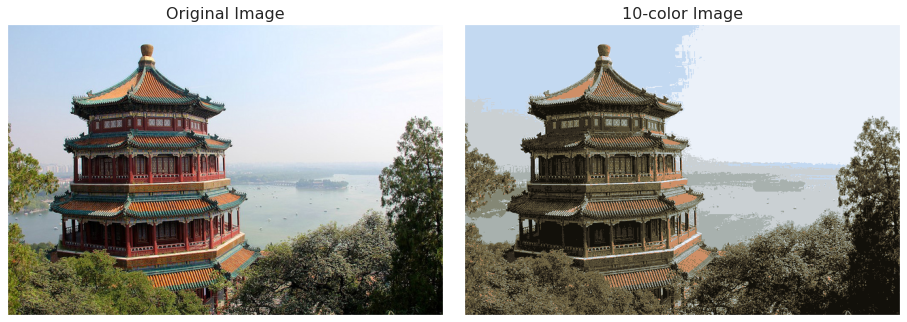

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('10-color Image', size=16);

In [ ]:
from sklearn.metrics import calinski_harabasz_score